In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import anndata 
import warnings

import pandas as pd

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import scanpy as sc
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import altair as alt
import pertpy as pt
import anndata as an

2023-12-19 17:16:25.777701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
adata = anndata.read("/media/gambino/students_workdir/ibp/Full_obj_log_counts_soupx_v2.h5ad")
adata

AnnData object with n_obs × n_vars = 428469 × 30535
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'Integrated_colors', 'category2_colors', 'category_colors', "dendrogram_['Integrated']", "dendrogram_['Integrated_05']", 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'

Here we need to reorder the categories, so that we can compare the small intestine to the other regions

In [3]:
adata.obs["Region"] = adata.obs["Region"].cat.reorder_categories(["SmallInt","LargeInt","APD","REC","lymph node"])
adata.obs["Region"]

AAACCTGAGAACAACT-1-4918STDY7333456    SmallInt
AAACCTGAGCGATATA-1-4918STDY7333456    SmallInt
AAACCTGAGGAGTTTA-1-4918STDY7333456    SmallInt
AAACCTGAGTATCTCG-1-4918STDY7333456    SmallInt
AAACCTGAGTGACTCT-1-4918STDY7333456    SmallInt
                                        ...   
TTTGGTTTCAACACGT-1-WTDAtest7770719    LargeInt
TTTGGTTTCCAAATGC-1-WTDAtest7770719    LargeInt
TTTGGTTTCGGCGGTT-1-WTDAtest7770719    LargeInt
TTTGTCAGTGAAAGAG-1-WTDAtest7770719    LargeInt
TTTGTCATCTTGACGA-1-WTDAtest7770719    LargeInt
Name: Region, Length: 428469, dtype: category
Categories (5, object): ['SmallInt', 'LargeInt', 'APD', 'REC', 'lymph node']

Making the Sccoda model with the category labels

In [4]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="category",
    sample_identifier="batch",
    covariate_obs=["Region"],
)
sccoda_data

MuData object with n_obs × n_vars = 428628 × 30544
  var:	'n_cells'
  2 modalities
    rna:	428469 x 30535
      obs:	'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05', 'scCODA_sample_id'
      var:	'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'Integrated_colors', 'category2_colors', 'category_colors', "dendrogram_['Integrated']", "dendrogram_['Integrated_05']", 'hvg', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
    coda:	159 x 9
      obs:	'Region', 'batch'
      var:	'n_cells'

In [5]:
data_all= sccoda_data.mod["coda"]

We prepare the sccoda model with the reference cell type as Myeloid, because it stays fairly constant throughout the different region. However, it's below sccoda's level to be selected automatically, so afterwards we'll prepare a model that alternates the reference celltype and count how often compositional differences appear

In [6]:
model = mod.CompositionalAnalysis(data_all, formula="Region",reference_cell_type="Myeloid")

Zero counts encountered in data! Added a pseudocount of 0.5.


<Axes: xlabel='Cell type', ylabel='Proportion'>

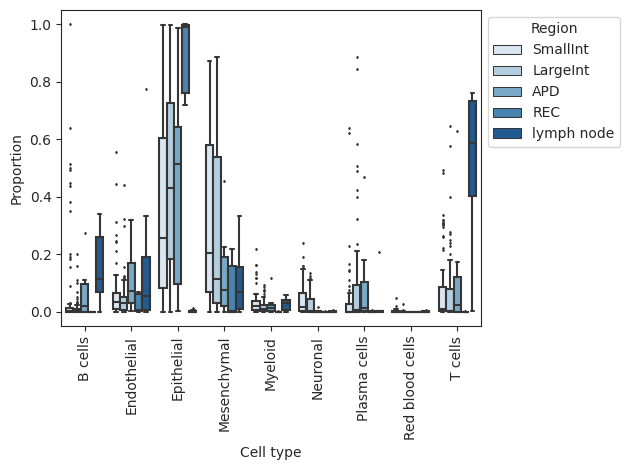

In [7]:
viz.boxplots(data_all,feature_name="Region")

In [8]:
conditions = adata.obs["Region"].unique()
cell_types = adata.obs["category"].unique()
outlist = [(i,j) 
           for i in conditions
           for j in cell_types]
print(outlist)
results_cycle = pd.DataFrame(data=outlist)
results_cycle["times_credible"]=[0]*len(results_cycle[0])
results_cycle.columns=["Covariate","Cell Type","times_credible"]


[('SmallInt', 'B cells'), ('SmallInt', 'T cells'), ('SmallInt', 'Epithelial'), ('SmallInt', 'Mesenchymal'), ('SmallInt', 'Plasma cells'), ('SmallInt', 'Myeloid'), ('SmallInt', 'Endothelial'), ('SmallInt', 'Neuronal'), ('SmallInt', 'Red blood cells'), ('LargeInt', 'B cells'), ('LargeInt', 'T cells'), ('LargeInt', 'Epithelial'), ('LargeInt', 'Mesenchymal'), ('LargeInt', 'Plasma cells'), ('LargeInt', 'Myeloid'), ('LargeInt', 'Endothelial'), ('LargeInt', 'Neuronal'), ('LargeInt', 'Red blood cells'), ('APD', 'B cells'), ('APD', 'T cells'), ('APD', 'Epithelial'), ('APD', 'Mesenchymal'), ('APD', 'Plasma cells'), ('APD', 'Myeloid'), ('APD', 'Endothelial'), ('APD', 'Neuronal'), ('APD', 'Red blood cells'), ('lymph node', 'B cells'), ('lymph node', 'T cells'), ('lymph node', 'Epithelial'), ('lymph node', 'Mesenchymal'), ('lymph node', 'Plasma cells'), ('lymph node', 'Myeloid'), ('lymph node', 'Endothelial'), ('lymph node', 'Neuronal'), ('lymph node', 'Red blood cells'), ('REC', 'B cells'), ('REC'

Here we run a loop to cycle through each category and use each as a reference and count the number of times the model returns a significantly different result

In [9]:
for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(data_all, formula="Region", reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    test = temp_results.credible_effects().reset_index()
    test["Final Parameter"] = test["Final Parameter"].astype("int")
    test['Covariate'] = test.Covariate.apply(lambda x: x[12:-1])
    results_cycle = pd.merge(test,results_cycle,how='right',on=["Covariate","Cell Type"])
    results_cycle['Final Parameter'] = results_cycle['Final Parameter'].fillna(0)
    results_cycle['times_credible'] = results_cycle['Final Parameter'] + results_cycle["times_credible"]
    results_cycle = results_cycle.drop(columns=["Final Parameter"])
    # add up credible effects
    print(results_cycle)


Reference: B cells
Zero counts encountered in data! Added a pseudocount of 0.5.


  0%|          | 0/20000 [00:00<?, ?it/s]2023-12-19 17:18:09.202920: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f834c00bcd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-19 17:18:09.202960: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-19 17:18:09.621632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703002690.780728 2175515 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-12-19 17:18:10.795163: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
100%|██████████| 20000/20000 [02:36<00:00, 127.62it/s]


MCMC sampling finished. (198.080 sec)
Acceptance rate: 79.6%
     Covariate        Cell Type  times_credible
0     SmallInt          B cells             0.0
1     SmallInt          T cells             0.0
2     SmallInt       Epithelial             0.0
3     SmallInt      Mesenchymal             0.0
4     SmallInt     Plasma cells             0.0
5     SmallInt          Myeloid             0.0
6     SmallInt      Endothelial             0.0
7     SmallInt         Neuronal             0.0
8     SmallInt  Red blood cells             0.0
9     LargeInt          B cells             0.0
10    LargeInt          T cells             0.0
11    LargeInt       Epithelial             0.0
12    LargeInt      Mesenchymal             0.0
13    LargeInt     Plasma cells             0.0
14    LargeInt          Myeloid             0.0
15    LargeInt      Endothelial             0.0
16    LargeInt         Neuronal             0.0
17    LargeInt  Red blood cells             0.0
18         APD          B c

100%|██████████| 20000/20000 [02:36<00:00, 127.95it/s]


MCMC sampling finished. (197.091 sec)
Acceptance rate: 52.9%
     Covariate        Cell Type  times_credible
0     SmallInt          B cells             0.0
1     SmallInt          T cells             0.0
2     SmallInt       Epithelial             0.0
3     SmallInt      Mesenchymal             0.0
4     SmallInt     Plasma cells             0.0
5     SmallInt          Myeloid             0.0
6     SmallInt      Endothelial             0.0
7     SmallInt         Neuronal             0.0
8     SmallInt  Red blood cells             0.0
9     LargeInt          B cells             0.0
10    LargeInt          T cells             0.0
11    LargeInt       Epithelial             0.0
12    LargeInt      Mesenchymal             0.0
13    LargeInt     Plasma cells             0.0
14    LargeInt          Myeloid             0.0
15    LargeInt      Endothelial             0.0
16    LargeInt         Neuronal             0.0
17    LargeInt  Red blood cells             0.0
18         APD          B c

100%|██████████| 20000/20000 [02:42<00:00, 122.93it/s]


MCMC sampling finished. (203.632 sec)
Acceptance rate: 56.4%
     Covariate        Cell Type  times_credible
0     SmallInt          B cells             0.0
1     SmallInt          T cells             0.0
2     SmallInt       Epithelial             0.0
3     SmallInt      Mesenchymal             0.0
4     SmallInt     Plasma cells             0.0
5     SmallInt          Myeloid             0.0
6     SmallInt      Endothelial             0.0
7     SmallInt         Neuronal             0.0
8     SmallInt  Red blood cells             0.0
9     LargeInt          B cells             0.0
10    LargeInt          T cells             0.0
11    LargeInt       Epithelial             0.0
12    LargeInt      Mesenchymal             0.0
13    LargeInt     Plasma cells             0.0
14    LargeInt          Myeloid             0.0
15    LargeInt      Endothelial             0.0
16    LargeInt         Neuronal             0.0
17    LargeInt  Red blood cells             0.0
18         APD          B c

100%|██████████| 20000/20000 [02:34<00:00, 129.05it/s]


MCMC sampling finished. (195.267 sec)
Acceptance rate: 58.2%
     Covariate        Cell Type  times_credible
0     SmallInt          B cells             0.0
1     SmallInt          T cells             0.0
2     SmallInt       Epithelial             0.0
3     SmallInt      Mesenchymal             0.0
4     SmallInt     Plasma cells             0.0
5     SmallInt          Myeloid             0.0
6     SmallInt      Endothelial             0.0
7     SmallInt         Neuronal             0.0
8     SmallInt  Red blood cells             0.0
9     LargeInt          B cells             0.0
10    LargeInt          T cells             0.0
11    LargeInt       Epithelial             0.0
12    LargeInt      Mesenchymal             0.0
13    LargeInt     Plasma cells             0.0
14    LargeInt          Myeloid             0.0
15    LargeInt      Endothelial             0.0
16    LargeInt         Neuronal             0.0
17    LargeInt  Red blood cells             0.0
18         APD          B c

100%|██████████| 20000/20000 [02:34<00:00, 129.22it/s]


MCMC sampling finished. (195.083 sec)
Acceptance rate: 44.5%
     Covariate        Cell Type  times_credible
0     SmallInt          B cells             0.0
1     SmallInt          T cells             0.0
2     SmallInt       Epithelial             0.0
3     SmallInt      Mesenchymal             0.0
4     SmallInt     Plasma cells             0.0
5     SmallInt          Myeloid             0.0
6     SmallInt      Endothelial             0.0
7     SmallInt         Neuronal             0.0
8     SmallInt  Red blood cells             0.0
9     LargeInt          B cells             0.0
10    LargeInt          T cells             0.0
11    LargeInt       Epithelial             0.0
12    LargeInt      Mesenchymal             0.0
13    LargeInt     Plasma cells             0.0
14    LargeInt          Myeloid             0.0
15    LargeInt      Endothelial             0.0
16    LargeInt         Neuronal             0.0
17    LargeInt  Red blood cells             0.0
18         APD          B c

100%|██████████| 20000/20000 [02:35<00:00, 128.80it/s]


MCMC sampling finished. (195.810 sec)
Acceptance rate: 63.6%
     Covariate        Cell Type  times_credible
0     SmallInt          B cells             0.0
1     SmallInt          T cells             0.0
2     SmallInt       Epithelial             0.0
3     SmallInt      Mesenchymal             0.0
4     SmallInt     Plasma cells             0.0
5     SmallInt          Myeloid             0.0
6     SmallInt      Endothelial             0.0
7     SmallInt         Neuronal             0.0
8     SmallInt  Red blood cells             0.0
9     LargeInt          B cells             0.0
10    LargeInt          T cells             0.0
11    LargeInt       Epithelial             0.0
12    LargeInt      Mesenchymal             0.0
13    LargeInt     Plasma cells             0.0
14    LargeInt          Myeloid             0.0
15    LargeInt      Endothelial             0.0
16    LargeInt         Neuronal             0.0
17    LargeInt  Red blood cells             0.0
18         APD          B c

100%|██████████| 20000/20000 [02:34<00:00, 129.13it/s]


MCMC sampling finished. (195.514 sec)
Acceptance rate: 49.2%
     Covariate        Cell Type  times_credible
0     SmallInt          B cells             0.0
1     SmallInt          T cells             0.0
2     SmallInt       Epithelial             0.0
3     SmallInt      Mesenchymal             0.0
4     SmallInt     Plasma cells             0.0
5     SmallInt          Myeloid             0.0
6     SmallInt      Endothelial             0.0
7     SmallInt         Neuronal             0.0
8     SmallInt  Red blood cells             0.0
9     LargeInt          B cells             0.0
10    LargeInt          T cells             0.0
11    LargeInt       Epithelial             0.0
12    LargeInt      Mesenchymal             0.0
13    LargeInt     Plasma cells             0.0
14    LargeInt          Myeloid             0.0
15    LargeInt      Endothelial             0.0
16    LargeInt         Neuronal             0.0
17    LargeInt  Red blood cells             0.0
18         APD          B c

100%|██████████| 20000/20000 [02:35<00:00, 128.88it/s]


MCMC sampling finished. (195.415 sec)
Acceptance rate: 54.7%
     Covariate        Cell Type  times_credible
0     SmallInt          B cells             0.0
1     SmallInt          T cells             0.0
2     SmallInt       Epithelial             0.0
3     SmallInt      Mesenchymal             0.0
4     SmallInt     Plasma cells             0.0
5     SmallInt          Myeloid             0.0
6     SmallInt      Endothelial             0.0
7     SmallInt         Neuronal             0.0
8     SmallInt  Red blood cells             0.0
9     LargeInt          B cells             0.0
10    LargeInt          T cells             0.0
11    LargeInt       Epithelial             0.0
12    LargeInt      Mesenchymal             0.0
13    LargeInt     Plasma cells             0.0
14    LargeInt          Myeloid             0.0
15    LargeInt      Endothelial             0.0
16    LargeInt         Neuronal             0.0
17    LargeInt  Red blood cells             0.0
18         APD          B c

100%|██████████| 20000/20000 [02:35<00:00, 128.64it/s]


MCMC sampling finished. (196.216 sec)
Acceptance rate: 45.1%
     Covariate        Cell Type  times_credible
0     SmallInt          B cells             0.0
1     SmallInt          T cells             0.0
2     SmallInt       Epithelial             0.0
3     SmallInt      Mesenchymal             0.0
4     SmallInt     Plasma cells             0.0
5     SmallInt          Myeloid             0.0
6     SmallInt      Endothelial             0.0
7     SmallInt         Neuronal             0.0
8     SmallInt  Red blood cells             0.0
9     LargeInt          B cells             0.0
10    LargeInt          T cells             0.0
11    LargeInt       Epithelial             0.0
12    LargeInt      Mesenchymal             0.0
13    LargeInt     Plasma cells             0.0
14    LargeInt          Myeloid             0.0
15    LargeInt      Endothelial             0.0
16    LargeInt         Neuronal             0.0
17    LargeInt  Red blood cells             0.0
18         APD          B c

In [10]:
results_cycle["pct_credible"] = results_cycle["times_credible"]/len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5
print(results_cycle)

     Covariate        Cell Type  times_credible  pct_credible  is_credible
0     SmallInt          B cells             0.0           0.0        False
1     SmallInt          T cells             0.0           0.0        False
2     SmallInt       Epithelial             0.0           0.0        False
3     SmallInt      Mesenchymal             0.0           0.0        False
4     SmallInt     Plasma cells             0.0           0.0        False
5     SmallInt          Myeloid             0.0           0.0        False
6     SmallInt      Endothelial             0.0           0.0        False
7     SmallInt         Neuronal             0.0           0.0        False
8     SmallInt  Red blood cells             0.0           0.0        False
9     LargeInt          B cells             0.0           0.0        False
10    LargeInt          T cells             0.0           0.0        False
11    LargeInt       Epithelial             0.0           0.0        False
12    LargeInt      Mesen